Predict Daily Bike Rental Ridership

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Load and observe the data

In [2]:
data_path = 'hour.csv'
rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Shown above is a glimse of the dataset that we will be working with,
however we need to analyze it in a more broad spectrum. Lets first 
plot the numbers of bike rentals for 10 given days, looking above we have information about the temperature, the humidity, windspeed etc. of those given days and their impact on the bike rentals.

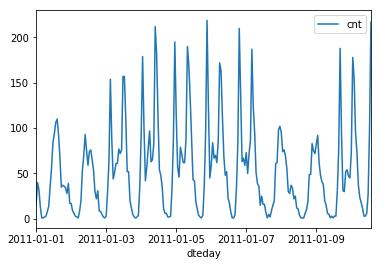

In [4]:
rides[:10*24].plot(x="dteday", y='cnt')
plt.show()

Above, we can see that the dips in bike rentals during the weekends. Let us plot some other catageries to see the effect on the bike rentals.

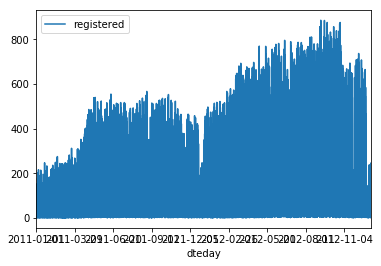

In [5]:
rides[:].plot(x="dteday", y='registered')
plt.show()

Above we can observe that the numbers of registered increases as time increases

In the dataset, we have categorical variables such as season, weather, month. To include those in out model, we'll need to make a binary dummy variables by using get_dummies() in the Pandas library


In [6]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix = each, drop_first= False)
    rides = pd.concat([rides, dummies], axis=1)
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit',
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


Standardizing Data

To make the training much easier on the network, we need to standardize each of the contineous variables, this means that each variable will have a mean of zero and a standard deviation of 1

In [7]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
normalized_features = {}   # Store the normalized features in a dictionary
for each in quant_features:
    mean = data[each].mean()
    std = data[each].std()
    normalized_features[each] = [mean,std]
    data.loc[:, each] = (data[each] - mean)/std

In [8]:
print(normalized_features)

{'casual': [35.67621842453536, 49.305030387053186], 'registered': [153.78686920996606, 151.35728591258317], 'cnt': [189.46308763450142, 181.38759909186527], 'temp': [0.4969871684216586, 0.19255612124972407], 'hum': [0.6272288394038822, 0.1929298340629125], 'windspeed': [0.1900976063064631, 0.12234022857279413]}


In [9]:
print(data)

       yr  holiday      temp       hum  windspeed    casual  registered  \
0       0        0 -1.334609  0.947345  -1.553844 -0.662736   -0.930162   
1       0        0 -1.438475  0.895513  -1.553844 -0.561326   -0.804632   
2       0        0 -1.438475  0.895513  -1.553844 -0.622172   -0.837666   
3       0        0 -1.334609  0.636351  -1.553844 -0.662736   -0.949983   
4       0        0 -1.334609  0.636351  -1.553844 -0.723582   -1.009445   
5       0        0 -1.334609  0.636351  -0.821460 -0.723582   -1.009445   
6       0        0 -1.438475  0.895513  -1.553844 -0.683018   -1.016052   
7       0        0 -1.542341  1.206507  -1.553844 -0.703300   -1.002838   
8       0        0 -1.334609  0.636351  -1.553844 -0.703300   -0.969804   
9       0        0 -0.919146  0.688184  -1.553844 -0.561326   -0.976411   
10      0        0 -0.607548  0.688184   0.519881 -0.480199   -0.857487   
11      0        0 -0.711414  0.947345   0.764282 -0.196252   -0.817845   
12      0        0 -0.399

Above, you can see the before and after effect of normalizing the data.

Splitting the data into training, testing, and validation sets

We will use the last 21 days of out data to test out the training network and ake predictions and compare them to the actual numbers.

In [10]:
#save the last 21 days of our data set
test_data = data[-21*24:]
#lets remove the test data from the data set
data = data[:-21*24] #here we are updating the data

#seperate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We will split the data now into two sets, one for the training and one for the validation

In [11]:
#hold out the last 60 days of the remaining data as a validation set
train_features, train_targets = features [:-24*60], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]


In [12]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))   
        
        def sigmoid_derivative(x):
            return x * (1 - x)
        
        #Implement leaky relu - for some reason , it makes almost no different with relu
        def relu(x):
            if (np.any(x>0)):
                return x
            else:
                return (0.01 * x)
                
        def relu_derivative(x):
            if (np.any(x>0)):
                return 1
            else:
                return 0.01
        
        
        self.activation_function = sigmoid
        self.activation_derivative_function = sigmoid_derivative

    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            ### Forward pass ###
            ##Hidden layer
            
            #Result of multiplication of weights and input 
            hidden_inputs = np.dot(X,self.weights_input_to_hidden) 
            
            #Putting the values that we got from previuos multiplication through activation function to get hidden layer values.
            hidden_outputs = self.activation_function(hidden_inputs) 

            
            ##Output layer
            
            #Result of multiplication of weights and input 
            final_inputs = np.dot(hidden_outputs,self.weights_hidden_to_output) 
            #With Activatio function :Putting the values that we got from previuos multiplication through activation function to get final output values.
            #final_outputs = self.activation_function(final_inputs)  
            #Without activation Function
            final_outputs = final_inputs 
            
            ### Backward pass ###
            # Output layer error is the difference between desired target and actual output.
            error = y-final_outputs 
            
            #If there is no activation funtion at the output layer ( x= Y )
            output_layer_grad = 1
            
            output_error_term = error * output_layer_grad
            hidden_error = np.dot(self.weights_hidden_to_output,output_error_term)

            hidden_layer_grad = self.activation_derivative_function(hidden_outputs)
            hidden_error_term = hidden_error * hidden_layer_grad


            # Weight step (input to hidden)
            delta_weights_i_h += hidden_error_term*X[:,None]
            # Weight step (hidden to output)
            delta_weights_h_o += output_error_term*hidden_outputs[:,None]


        # TODO: Update the weights - Replace these values with your calculations.
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records 
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records 
    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Implement the forward pass here ####
        hidden_inputs = np.dot(features, self.weights_input_to_hidden ) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(hidden_outputs,self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs  # signals from final output layer 
        
        return final_outputs 
        
        

In [13]:
def MSE (y,Y):
    return np.mean((y-Y)**2)

In [ ]:

import sys

iterations = 20000
learning_rate = 0.1
hidden_nodes = 15
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

In [ ]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize = (8,4))

mean, std = normalized_features['cnt']
predictions = network.run(test_features).T*std +mean
ax.plot(predictions[0],label='Predictions')
ax.plot((test_targets['cnt']*std+mean).values, label = 'Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d:d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation = 46)
plt.show()